<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Viral_and_Bacterial_Variant_Calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Viral and Bacterial Variant Calling</h1>

The tutorial is a short demonstration of how to perfrom small variant calling in viral and bacterial samples (or more generically any sample that is ploidy-1).

Questions answered by this tutorial include:

* How does my sample differ from a reference sequence?
* What is the level of evidence for these variants in my data?
* What tools can I use to programatically manipulate VCF files.

Methods used in this tutorial include:

* `medaka` for variant calling and annotation.
* `pomoxis` for basic data QC.
* `pysam` for iterating through VCF files.
* `pandas` for manipulating VCF files as a table.
* `bcftools` for filtering VCF files on the command-line.

Computational requirements for this tutorial:

* A computer running the EPI2ME Labs Server environment
* 16Gb RAM

> ⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.



## Introduction

This tutorial aims to demonstrate how `medaka` can be used to detect small variants in a haploid sample. Medaka has not been explicitely developed for this task but it is a task so closely related to calculating a consensus that it is a task to which `medaka` is ideally suited.

The goals from this tutorial include:

* Understand how to use `medaka` to call small variants in a haploid sample
* Learn how to use `medaka`'s ancilliary tools to annotate variants with evidence statistics
* Understand the basic concepts of a Variant Call Format (VCF) file and how to manipulate such files using a range of software tools.

The tutorial includes a small sample dataset from a B.subtilis sample. The workflow demonstrated below has been successfully used in the [ARTIC](https://artic.network/ncov-2019) bioinformatics pipeline for calling variants in SARS-CoV-2019 samples.

## Getting started

⚠️  ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See [Run a tutorial](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#scrollTo=r--DdCunUR6Y) on the EPI2ME Labs Server help page for more information.

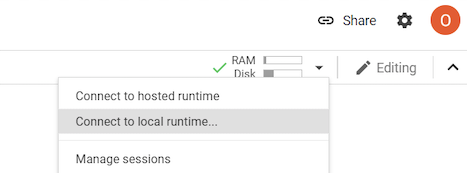

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [1]:
from epi2melabs import ping
tutorial_name = "bacterial-snp"
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/bacterial-snp


### Sample Data

In order to demonstrate the abilities of this notebook, a small sample dataset from a B.subtilis isolate is included together with a reference sequence.

To download the sample file we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)
site = "https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com"

!mkdir -p sample_data
!cd sample_data && wget $site/lc2020/bsubtilis.reads.fasta.gz
!cd sample_data && wget $site/lc2020/bsubtilis.ref.fasta

### Using your own data

If you have your own sequencing, you can edit the value of the input variables below in the **Data Entry** section. To find the correct full path of a file you can navigate to it in the **Files** browser to the left-hand side, right-click on the file and select **Copy path**:

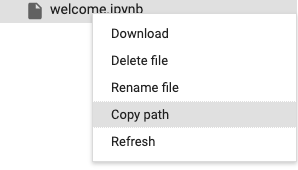

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook.

The form can be used to enter the filenames of your inputs. Alternatively you can edit the code which reads the inputs by first double clicking the form header. After entering your inputs (or editing the code cell) remember to execute the code using `Command/Ctrl-Enter`, or pressing the `Play` symbol to the left-hand side.

>**If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run after` from the `Runtime` menu above after entering your filepath.**

In [4]:
#@markdown Enter the paths to you input files and output folder here. The input data may be either a a single fastq, compressed or otherwise, file or a directory containing multiple such files: (*click **here** to view code*)
# load the pandas library
import aplanat
import aplanat.graphics
import aplanat.report
import pandas as pd
import os

# set variables for our inputs
input_data = 'sample_data/bsubtilis.reads.fasta.gz'  #@param {type: "string"}
output_folder = 'analysis'  #@param {type: "string"}
reference_genome = 'sample_data/bsubtilis.ref.fasta' #@param {type: "string"}
#@markdown Choose a medaka model and number of compute threads. For choosing a
#@markdown medaka model please refer to [Sequence Correction](https://nanoporetech.github.io/medaka/installation.html#sequence-correction)
#@markdown in the medaka documentation.
medaka_model  = "r10_min_high_g340" #@param {type: "string"}
threads =  4#@param {type: "integer"}

input_data = os.path.abspath(input_data)
input_fastq = os.path.join(output_folder, "input.fastq")
if input_data.endswith(".gz"):
    input_fastq += ".gz"

# run a command to concatenate all the files together
!echo "Making output folder"
!mkdir -p "$output_folder"
!test -f "$reference_genome" || "WARNING: Reference file does not exist"
!rationalise_fastq -i "$input_data" -o "$input_fastq"

exec_summary = aplanat.graphics.InfoGraphItems()
report = aplanat.report.HTMLReport(
    "Haploid Small Variant Calling", "EPI2ME Labs Summary")
report.plot(None, key='exec-plot')  # placeholder


Making output folder
Input: /epi2melabs/bacterial-snp/sample_data/bsubtilis.reads.fasta.gz
Output: /epi2melabs/bacterial-snp/analysis/input.fastq.gz
Output exists, exiting


Executing the above form will have checked input files and configured the following analyses.

### Preliminary Analysis Section

To verify the data we have is suitable for performing variant calling we can align the reads to the reference sequence to check the accuracy of the reads and their coverage of the genome:

In [5]:
#@markdown **Calculating read accuracy and genome coverage** *(click here to show)*
# run alignments
data_prefix = os.path.join(output_folder, "reads2ref")
!mini_align -t $threads \
    -r $reference_genome -i $input_fastq \
    -p "$data_prefix"
# calculate read stats
!stats_from_bam "$data_prefix".bam > "$data_prefix".bam.stats
# calculate depth
!mosdepth -t 2 --flag 1812 "$data_prefix".fwd "$data_prefix".bam 
!mosdepth -t 2 --flag 1796 --include-flag 16 "$data_prefix".rev "$data_prefix".bam
# show regions in bam
print("Available regions:")
with open(reference_genome + '.fai') as fh:
    for line in (x.split() for x in fh.readlines()):
        print('  {}:0-{}'.format(*line[:2]))

Constructing minimap index.
[M::mm_idx_gen::0.133*1.16] collected minimizers
[M::mm_idx_gen::0.171*1.55] sorted minimizers
[M::main::0.215*1.44] loaded/built the index for 2 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 2
[M::mm_idx_stat::0.222*1.43] distinct minimizers: 737336 (98.05% are singletons); average occurrences: 1.038; average spacing: 5.345
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -I 16G -x map-ont -d sample_data/bsubtilis.ref.fasta.mmi sample_data/bsubtilis.ref.fasta
[M::main] Real time: 0.226 sec; CPU: 0.321 sec; Peak RSS: 0.041 GB
[M::main::0.051*1.05] loaded/built the index for 2 target sequence(s)
[M::mm_mapopt_update::0.061*1.04] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 2
[M::mm_idx_stat::0.068*1.04] distinct minimizers: 737336 (98.05% are singletons); average occurrences: 1.038; average spacing: 5.345
[M::worker_pipeline::37.738*3.96] mapped 5201 sequences
[M::worker_pipeline::58.187*3.88] map

The results of the above alignments and analysis can be visualised using the code cell below. 

In [6]:
from aplanat import annot, lines, hist, util
from bokeh.layouts import gridplot
import numpy as np

#@markdown Select a region based on those noted above. *(click to view code)*
region = "bsubtilis1:0-4065191" #@param {type:"string"}

from aplanat import points

try:
    chrom, coords = region.split(":")
    start, stop = (int(x) for x in coords.split("-"))
except Exception as e:
    print('Cannot parse region as "chrom:start-stop".')

def down_sample(df, plot_limit=10000):
    # if we have a lot of points, remove some to avoid bokeh dying.
    if len(df) > plot_limit:
        display("Warning: Downsampling points to {} entries. Select a smaller region to show all points.".format(plot_limit))
        df = df[::len(df) // plot_limit]
    else:
        display("Showing all sites.")
    return df

def read_depth(fname):
    df = pd.read_csv(
        fname, sep='\t',
        names=['ref', 'start', 'end', 'depth'])
    df = df.loc[
        (df['ref'] == chrom) & (df['start'] > start) & (df['end'] < stop)]
    df = down_sample(df).reset_index()
    return df

depth_fwd = read_depth('{}.fwd.per-base.bed.gz'.format(data_prefix))
depth_rev = read_depth('{}.rev.per-base.bed.gz'.format(data_prefix))

depth_plot = lines.steps(
    [depth_fwd['start'], depth_rev['start']],
    [depth_fwd['depth'], depth_rev['depth']],
    colors=['darkolivegreen', 'maroon'],
    names=['Forward', 'Reverse'],
    x_axis_label='Position along reference',
    y_axis_label='sequencing depth / bases')
depth_plot.xaxis.formatter.use_scientific = False

stats = pd.read_csv("{}.bam.stats".format(data_prefix), sep='\t')
x_grid, pdf = util.kernel_density_estimate(stats['acc'])
mode = x_grid[np.argmax(pdf)]
acc_plot = lines.line(
    [x_grid], [pdf],
    x_axis_label="read accuracy", y_axis_label="read density")
acc_plot = annot.marker_vline(acc_plot, mode, label='mode: {:.1f}'.format(mode))

plot = gridplot([acc_plot, depth_plot], ncols=2)
aplanat.show(plot)
report.markdown(
    "Read metrics with respect to the provided reference are shown below.",
    key="read-stats-lead")
report.plot(plot, key='read-plots')

'Warning: Downsampling points to 10000 entries. Select a smaller region to show all points.'

'Warning: Downsampling points to 10000 entries. Select a smaller region to show all points.'

The left-hand plot depicts read accuracy and should contain a peak at or above 93%. The right-hand coverage plot will reveal regions of low coverage. In such regions variant calling may prove more difficult (but not impossible); this should be taken into account when evaluating variants in the next section.

## Variant Calling with medaka

The section above provides a basic QC of the input data: if the reads appear of a good quality with repect to the reference sequence and there is good coverage of reads across the reference it is time to perform variant calling.

### Calling variants

Using `medaka` to perform variant calling requires three steps:

1.   Run `medaka`'s consensus recurrent neural network (RNN) on the alignments produced above to create a set of base probabilities in an `.hdf` file:
2.   Convert the RNN output into a standard Variant Call Format (`.vcf`) file
3.   Annotate the `.vcf` with read support information.

The code block below performs these three steps:

In [8]:
# clean previous efforts
from epi2melabs import notebook
print(notebook.ok("Step 1: running neural network"))
!rm -rf "$data_prefix".hdf
!run medaka consensus "$data_prefix".bam "$data_prefix".hdf \
    --threads $threads --model $medaka_model
print(notebook.ok("Step 2: calculating variants"))
!run medaka variant $reference_genome "$data_prefix".hdf "$data_prefix".vcf.tmp
print(notebook.ok("Step 3: annotating variant calls"))
!run medaka tools annotate "$data_prefix".vcf.tmp $reference_genome "$data_prefix".bam "$data_prefix".vcf
!rm "$data_prefix".vcf.tmp

Step 1: run RNN
Step 2: run variant calling
[13:58:58 - DataIndex] Loaded 1/1 (100.00%) sample files.
[13:58:58 - Variants] Processing bsubtilis1:0-.
Step 3: annotate variant calls


Calling variants is as simple as that! The above code block will have ultimately produced an VCF file annotated with read support information. These annotations are calculated by realigning all reads in the vicinity of a variant locus and determining which alternative sequence the read best supports

> **The outcome of the read support annotations may prove counter-intuitive. The neural network used within Medaka can be considered as encoding knowledge (prior beliefs) on the expected base distributions for alternative sequences. In the presence of errorful reads the neural network provides additional power over naively counting bases. Users are advised not to trivially dismiss calls based on incongruent read counts.**

In the next section we will review the produced VCF to highlight aspects of it a user may wish to explore further.

## Reviewing the calls

The section above has produced a set of (small) variants, annotated them and output a VCF file. This section aims to provide a gentle introduction to the VCF format, show how to read and manipulate such files in Python, and introduce the standard `bcftools` suite of programs.

### Reading VCF files with Python

There are a variety of Python libraries that aim to provide reasonably intuitive access to the data contained within a VCF file. Here we will briefly introduce the specialist [`pysam.VariantFile`](https://pysam.readthedocs.io/en/latest/api.html#vcf-files) parser before using the `pandas` to manipulate the file as a basic tabular format.


#### Using pysam

To iterate through the first few records in a VCF using `pysam` and print the reference name, the reference position and the mutation implied by the variant record:

In [9]:
import itertools
from pysam import VariantFile
vcf = VariantFile(data_prefix + '.vcf')

for variant in itertools.islice(vcf.fetch(), 10):
    print(variant.chrom, variant.pos, variant.ref, ">", variant.alts[0])

bsubtilis1 310 A > AG
bsubtilis1 1046 GA > G
bsubtilis1 1075 C > CGGG
bsubtilis1 1083 C > CG
bsubtilis1 1141 A > G
bsubtilis1 1238 C > CG
bsubtilis1 1253 C > CG
bsubtilis1 1556 G > GC
bsubtilis1 1775 G > GC
bsubtilis1 1800 T > TC


Note how the non-reference, alternative sequence includes surrounding bases in the case of insertion and deletion variants.

In order to filter variants to those which for which the calling algorithm (in this case `medaka`) is more confident it is useful to examine the `QUAL` and `INFO` fields of the variant records. The `INFO` field is a set of `key=value` pairs, with a description contained within the header section of the file:

> NOTE: The information contained within in the `INFO` section is freely defined, and so can vary, by the program producing the VCF file.

In [10]:
# show the header information for the info fields
!grep "##INFO" $data_prefix'.vcf'

# show the data
for variant in itertools.islice(vcf.fetch(), 10):
    info = ' '.join(f'{k}={v}' for k, v in variant.info.iteritems())
    print(variant.chrom, variant.pos, variant.qual, info)

##INFO=<ID=DP,Number=1,Type=Integer,Description="Depth of reads at pos">
##INFO=<ID=DPS,Number=2,Type=Integer,Description="Depth of reads at pos by strand (fwd, rev)">
##INFO=<ID=DPSP,Number=1,Type=Integer,Description="Depth of reads spanning pos +-25">
##INFO=<ID=SR,Number=.,Type=Integer,Description="Depth of spanning reads by strand which best align to each allele (ref fwd, ref rev, alt1 fwd, alt1 rev, etc.)">
##INFO=<ID=AR,Number=2,Type=Integer,Description="Depth of ambiguous spanning reads by strand which align equally well to all alleles (fwd, rev)">
##INFO=<ID=SC,Number=.,Type=Integer,Description="Total alignment score to each allele of spanning reads by strand (ref fwd, ref rev, alt1 fwd, alt1 rev, etc.) aligned with parasail match 5, mismatch -4, open 5, extend 3">
bsubtilis1 310 61.45500183105469 AR=(0, 0) DP=91 DPS=(46, 45) DPSP=91 SC=(9789, 9932, 10125, 10301) SR=(5, 4, 41, 41)
bsubtilis1 1046 34.297000885009766 AR=(0, 0) DP=9 DPS=(6, 3) DPSP=93 SC=(10547, 10645, 10718, 1087

#### Using pandas

We could continue to manipulate the file `medaka` VCF file using `pysam` but for interaction with the `Python` ecosystem it can be easier to treat simply the VCF file as standard tabular data using `pandas`. For example the code below will parse the VCF in a way to allow easy plotting:

In [11]:
#@markdown **Parsing and plotting VCF data with pandas** *(click here to show code)*
import aplanat
from aplanat import points

def parse_vcf(fname, info_cols=None):
    """Parse a VCF file. The INFO column is parsed to a dictionary.

    :param info_cols: dict of field:dtype for INFO  fieldsto store
        as distinct column.
    """
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(fname, delimiter='\t', comment='#', names=header)
    vcf['INFO'] = vcf['INFO'].str.split(";").apply(lambda x: dict([y.split("=") for y in x]))
    rlen = vcf['REF'].apply(len)
    alen = vcf['ALT'].apply(len)
    vcf['type'] = 'sub'
    vcf.loc[rlen > alen, 'type'] = 'del'
    vcf.loc[rlen < alen, 'type'] = 'ins'
    if info_cols is not None:
        for field, dtype in info_cols.items():
            vcf[field] = vcf['INFO'].apply(lambda x: x.get(field, None))
            vcf[field] = vcf[field].astype(dtype)
    return vcf

vcf = parse_vcf(data_prefix + '.vcf', info_cols={'DP':int})
types = ['sub', 'ins', 'del']
plot = points.points(
    [vcf.loc[vcf['type'] == x, 'DP'] for x in types],
    [vcf.loc[vcf['type'] == x, 'QUAL'] for x in types],
    colors=['red', 'green', 'blue'], names=types,
    x_axis_label='sequencing depth', y_axis_label='variant quality',
    title='Variant call quality vs. sequencing depth')
aplanat.show(plot)


#### Using bcftools

Above we have shown two Python-based methods for interacting with VCF files. The first of these is useul for inspecting each variant in turn, whereas the second is useful for generic programming and creating views across variants.

Finally we will introduce [`bcftools`](http://www.htslib.org/doc/bcftools.html), a set of command-line tools for manipulating VCF files and their binary cousings: BCF files. Perhaps one of the most useful parts of `bcftools` with which to get started is the [`bcftools query`](http://www.htslib.org/doc/bcftools.html#query) command. The query command can be used to format a VCF in a user defined fashion, whilst performing filtering.

To create a tab-separated output for high quality variants with sequencing depth greater than 75 reads:

In [12]:
!bcftools query \
    --format '%CHROM\t%REF\t%FIRST_ALT\t%QUAL\t%TYPE\t%DP\n' \
    -i 'QUAL>30 && DP>75' \
    "$data_prefix".vcf | head

bsubtilis1	A	AG	61.455	INDEL	91
bsubtilis1	C	CGGG	77.678	INDEL	81
bsubtilis1	C	CG	60.206	INDEL	93
bsubtilis1	A	G	53.439	SNP	84
bsubtilis1	C	CG	64.466	INDEL	93
bsubtilis1	C	CG	60.786	INDEL	93
bsubtilis1	G	GC	50.486	INDEL	82
bsubtilis1	G	GC	57.476	INDEL	91
bsubtilis1	T	TC	48.445	INDEL	90
bsubtilis1	A	AG	30.982	INDEL	89


This is just one small example. The [expressions](http://www.htslib.org/doc/bcftools.html#expressions) section of the documention is a useful resource for understanding how to query and filter VCF files.

## Summary

In this notebook we have demonstrated some key methods for performing variant calling and inspection for haploid samples. Medaka was used to perform the variant calling whilst we illustrated several tools for manipulating the resulting VCF file.

The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
